In [54]:
# In this assingnment, we will be using Pandas dataframes
# to read, transform, and store MNIST images. Make sure
# you are familiar with its API:
# https://pandas.pydata.org/pandas-docs/stable/

import pandas as pd

In [55]:
# Enter here the Dataset ID that you have received in the spreadsheet.
# Make sure that you use the ID that was assigned to you, 
# otherwise your submission will be graded against the wrong images.
dataset_id = '20220924-234643_8f61b372ecdad5adbbff7e2f3798e5f3'

# Assignment datasets are stored in an AWS S3 bucket. The following code
# downloads your dataset (~300MB) directly into RAM. Optionally,
# you can save the datasets to the local disk, but that's really not required.
prefix = f'https://danylo-ucla.s3-us-west-2.amazonaws.com/app/storage/mnist/jobs/transform_repack/{dataset_id}'

# These three dataframes contain clean images. Use each dataframe
# to train, validate, and test your model, respectively.
train_clean_X = pd.read_parquet(f'{prefix}/train_clean_x.parquet')
validate_clean_X = pd.read_parquet(f'{prefix}/validate_clean_x.parquet')
test_clean_X = pd.read_parquet(f'{prefix}/test_clean_x.parquet')

# These dataframes are noisy versions of the dataframes above.
train_noisy_X = pd.read_parquet(f'{prefix}/train_noisy_x.parquet')
validate_noisy_X = pd.read_parquet(f'{prefix}/validate_noisy_x.parquet')
test_noisy_X = pd.read_parquet(f'{prefix}/test_noisy_x.parquet')

# This is the segment of the dataset that will be graded in this assignment.
# Your model has to denoise this dataframe, and you have to submit the denoised version of this dataframe.
score_noisy_X = pd.read_parquet(f'{prefix}/score_noisy_x.parquet')

# For additional context, these are labels (e.g. digits) corresponding
# to each image in the dataset. Use it to analyze which digits
# your models has more or less problems with. These dataframes
# should not be used as part of the training process itself,
# only for post-training analysis, if you wish so.
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

In [56]:
# While not strictly required for this assignment,
# you will probably want to plot images to
# have a visual understanding of the model's performance.
# You can use any Python plotting library, for example:
# https://matplotlib.org/contents.html

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [57]:
# Just as in the lecture slides, the input matrix
# has row vectors that hold pixels of a single 28x28 image.
# Note that the column vectors are individual locations on
# the 28x28 grid, but flattened in a row-major way (28x28=784).
train_clean_X.shape

(49000, 784)

In [58]:
example_id = 1

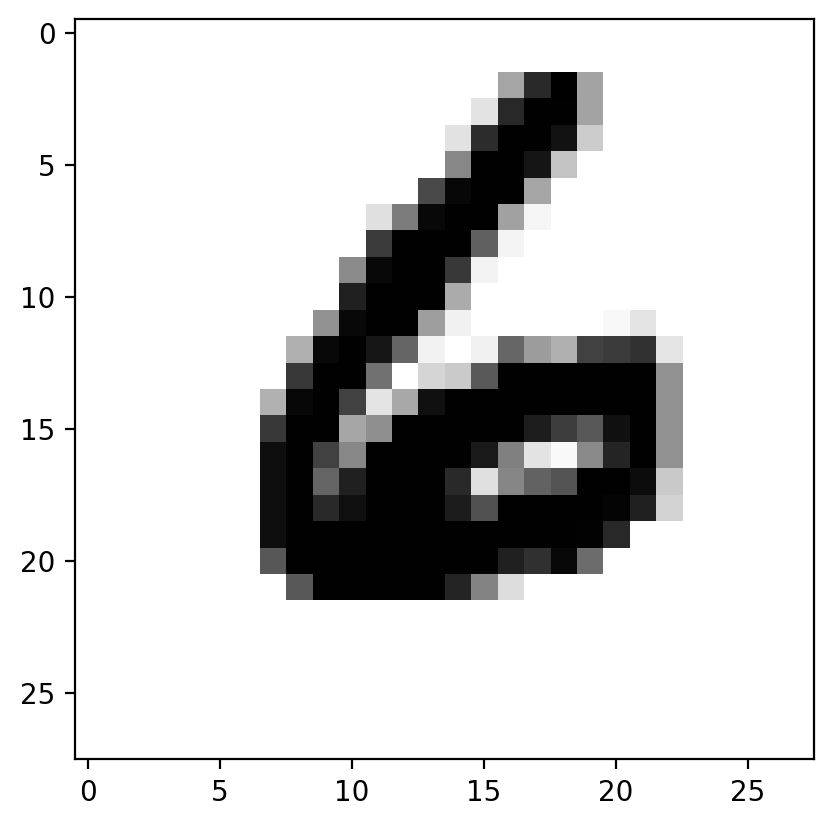

In [59]:
# Let's select a clean image from the dataset
image_pixels = train_clean_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the flattened array back into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

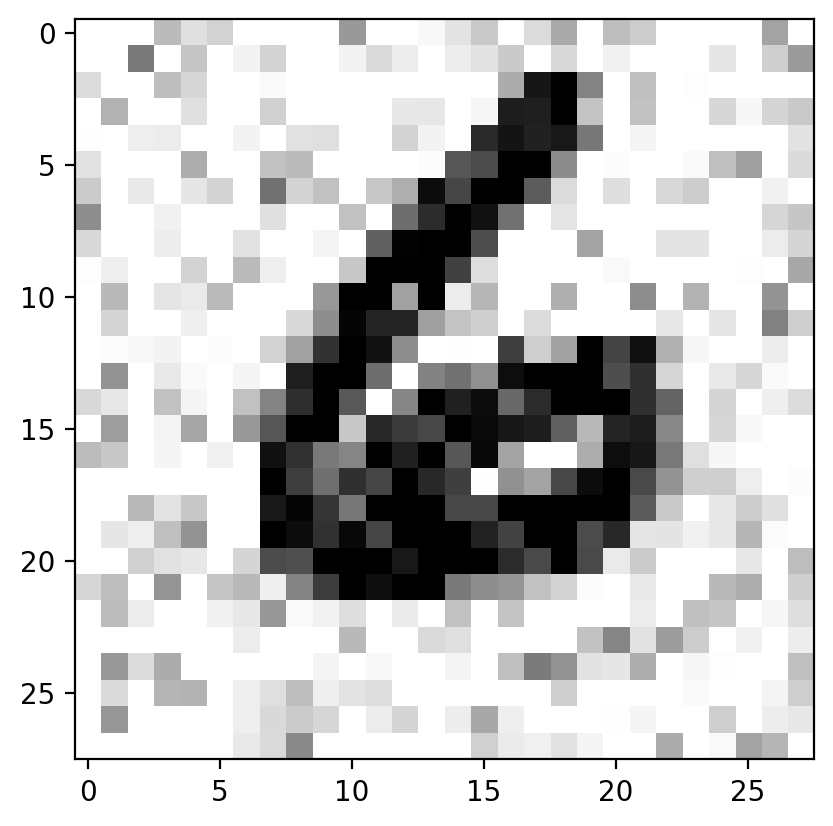

In [60]:
# Let's select a noisy image from the dataset
image_pixels = train_noisy_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the flattened array back into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

In [61]:
train_y.iloc[example_id]

digit    6
Name: 1, dtype: uint8

In [62]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

In [63]:
def sparse_regularizer(activation_matrix):
    p = 0.01
    beta = 3
    p_hat = K.mean(activation_matrix) 
  
    KL_divergence = p*(K.log(p/p_hat)) + (1-p)*(K.log(1-p/1-p_hat))
    
    sum = K.sum(KL_divergence) 
   
    return beta * sum

In [64]:
# In this couse, all assignments are expected to be
# implemented with Tensorflow framework.
# For this task, we can use its high-level Keras API:
# https://keras.io

from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

def build_model(hp: HyperParameters) -> tf.keras.Model:
    
    # IMPORTANT: This is an example of a very simple undercomplete autoencoder.
    # In other words, you will probably need to tweak these lines of code.
    
    layers = [
        # Encoder: 50 nodes, Exponential Linear Unit activation
        Dense(
            units=hp.Int('encoder_width', min_value=32, max_value=28*28, step=16), 
            activation='relu',
            input_shape=(28 * 28,)
        ),
        
        BatchNormalization(),
        LeakyReLU(),
        
        Dense(units=224, activation='tanh', activity_regularizer=regularizers.L1(0.0001)),
        Dense(units=224, activation='relu'),
        #Dense(524, activation='relu'),
        #Dense(128, activation = 'relu'),
        #Dense(32, activation = 'elu'),

        # Decoder: matches the shape of the image
        # Sigmoid activation is needed because pixel
        # values are real numbers between 0 (black) and 1 (white).
        #Dense(128, activation='relu'),
        #Dense(524, activation='relu'),
        
        BatchNormalization(),
        LeakyReLU(),
        Dense(units=28*28, activation='sigmoid')
    ]

    # Sequential class is a Keras class that attaches every 
    # layer's output to the next layer's input.
    # This is essentially a helper class for any feedforward networks.
    autoencoder = Sequential(layers)

    # Using MSE as the loss function, and Adam optimizer.
    # Other optimizers can also be used.
    autoencoder.compile(
        optimizer=optimizers.Adam(
            lr=hp.Float(name='learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
        ), 
        loss='mean_squared_error'
    )
    
    return autoencoder

In [65]:
# IMPORTANT: This is an example of a reconstruction training mode.
# Your autoencoder has to be trained in denoising mode.
# In other words, you will probably need to tweak these lines of code.

def train_model(model: tf.keras.Model, epochs: int) -> tf.keras.callbacks.History:
    history = model.fit(
        x=train_noisy_X, 
        y=train_clean_X, 

        # It's a good idea to have low number of epochs,
        # to test the learning process, but not for the final model training.
        epochs=epochs,

        batch_size=128,
        shuffle=True,
        validation_data=(validate_noisy_X, validate_clean_X)
    )
    return history

In [66]:
# In order to have reproducible results, we need
# to set the seed values for NumPy and Tensorflow.
# Keep these lines in the same cell as the training code,
# so that you don't accidentally train multiples models
# without reseting the seed.

import numpy as np
import tensorflow as tf

np.random.seed(11)
tf.random.set_seed(11)

hp = HyperParameters()
hp.Fixed('encoder_width', value=100)
hp.Fixed('learning_rate', value=1e-3)

autoencoder = build_model(hp)
history = train_model(autoencoder, epochs=50)

/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
383/383 [==============================] - 4s 8ms/step - loss: 0.0384 - val_loss: 0.0240
Epoch 2/50
383/383 [==============================] - 3s 7ms/step - loss: 0.0147 - val_loss: 0.0126
Epoch 3/50
383/383 [==============================] - 3s 7ms/step - loss: 0.0115 - val_loss: 0.0105
Epoch 4/50
383/383 [==============================] - 3s 7ms/step - loss: 0.0099 - val_loss: 0.0093
Epoch 5/50
383/383 [==============================] - 3s 7ms/step - loss: 0.0087 - val_loss: 0.0085
Epoch 6/50
383/383 [==============================] - 3s 8ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 7/50
383/383 [==============================] - 3s 7ms/step - loss: 0.0072 - val_loss: 0.0076
Epoch 8/50
383/383 [==============================] - 3s 7ms/step - loss: 0.0068 - val_loss: 0.0078
Epoch 9/50
383/383 [==============================] - 3s 8ms/step - loss: 0.0065 - val_loss: 0.0074
Epoch 10/50
383/383 [==============================] - 3s 8ms/step - loss: 0.0063 - val_loss: 0.0072

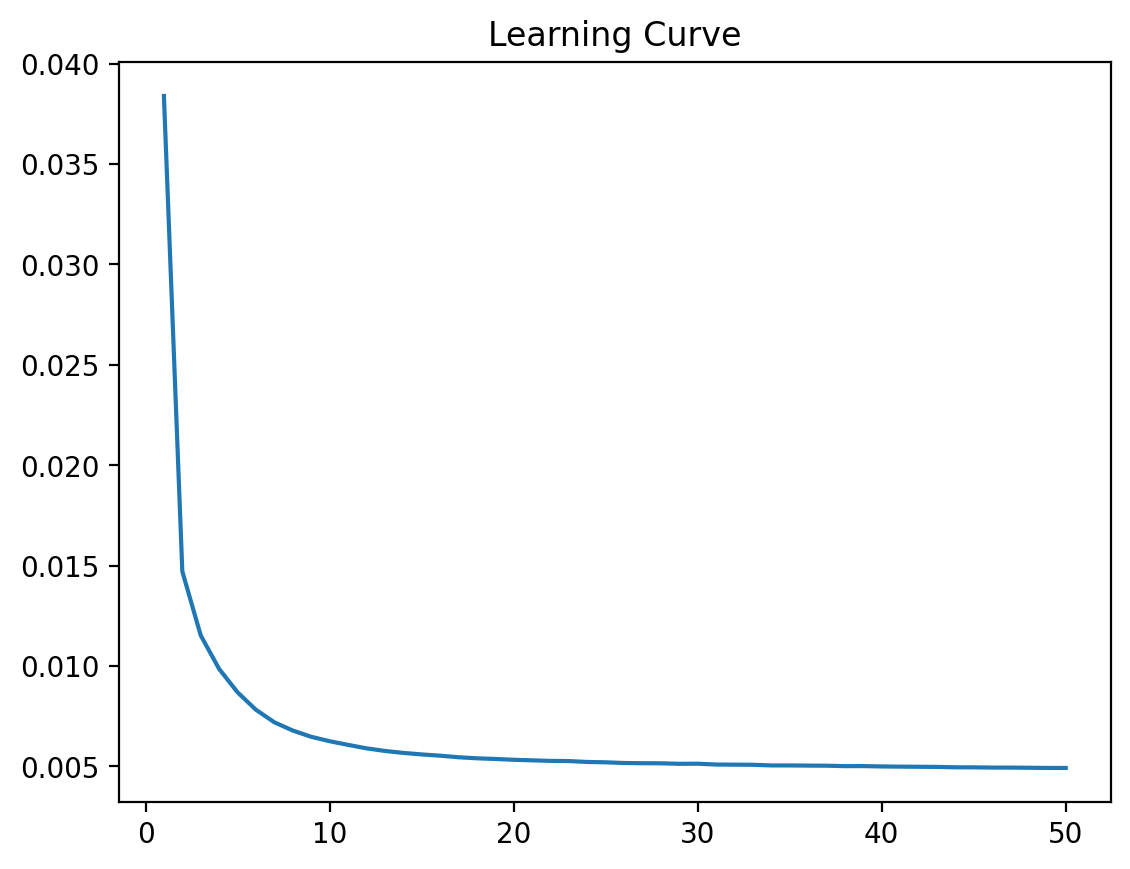

In [67]:
# The fit method returns a history object that
# can be used to plot the learning curve.

learning_curve = pd.Series(history.history['loss'])
learning_curve.index = learning_curve.index + 1

learning_curve.plot(title='Learning Curve')
#plt.xticks(learning_curve.index)
plt.show()

In [68]:
from kerastuner.tuners import RandomSearch

# A tuner implements a particular hyperoptimization strategy.
# This example uses a random search turner, which samples
# hyperparameter values from the distributions specified
# in the build_model function. You can use other tuners too:
# https://keras-team.github.io/keras-tuner/documentation/tuners/

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='denoiser_hyperop',
    seed = 11,
    # Experiment name must change if you modify
    # the model structure or the set of hyperparameters.
    project_name='autoencoder_01_34'
)

# This displays which hyperparameters are tunable, and their respective distribution.
tuner.search_space_summary()

Search space summary
Default search space size: 2
encoder_width (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 784, 'step': 16, 'sampling': None}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [69]:
import numpy as np
import tensorflow as tf
np.random.seed(11)
tf.random.set_seed(11)

# IMPORTANT: This is an example of a reconstruction training mode.
# Your autoencoder has to be trained in denoising mode.
# In other words, you will probably need to tweak these lines of code.

tuner.search(    
    # All parameters here are passed thru to Model.fit function.
    x=train_noisy_X, 
    y=train_clean_X, 
    
    # It's a good idea to have low number of epochs,
    # to test the learning process, but not for the final model training.
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(validate_noisy_X, validate_clean_X)
)

Trial 20 Complete [00h 00m 31s]
val_loss: 0.015103626064956188

Best val_loss So Far: 0.0064377873204648495
Total elapsed time: 00h 13m 02s
INFO:tensorflow:Oracle triggered exit


In [70]:
# The following function can be used to view the search summary.
#tuner.results_summary()

In [71]:
# The tuner's oracle property can be used to fetch information
# about every trial, which can be used to build a table like so.

pd.DataFrame([
    {
        'trial_id': t.trial_id,
        'score': t.score,
        **t.hyperparameters.values 
    }
    for t in tuner.oracle.get_best_trials(num_trials=10)
]).set_index('trial_id')

,score,encoder_width,learning_rate
trial_id,,,
05,0.006438,160,0.000825
17,0.007190,240,0.000598
04,0.007333,544,0.000648
07,0.008182,320,0.000312
06,0.008648,720,0.000266
13,0.009346,544,0.000190
15,0.009430,320,0.000190
18,0.011160,304,0.000125
09,0.011226,448,0.000120


In [72]:
# This returns the best model found during the search.
autoencoder = tuner.get_best_models(num_models=1)[0]

/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [73]:
# You can proceed with the above model, but it might 
# be also a good idea to do a final training pass with the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_hyperparameters.values
#autoencoder = build_model(best_hyperparameters)

{'encoder_width': 160, 'learning_rate': 0.0008249331566936491}

In [74]:
#autoencoder = build_model(best_hyperparameters)

In [75]:
# Now we can feed the noisy images into the autoencoder.
train_denoised_X = autoencoder.predict(train_noisy_X)

test_denoised_X = autoencoder.predict(test_noisy_X)
# Keras returns back a Numpy array, but we need Pandas dataframe,
# so let's quickly put the denoised images into a dataframe.
train_denoised_X = pd.DataFrame(train_denoised_X)

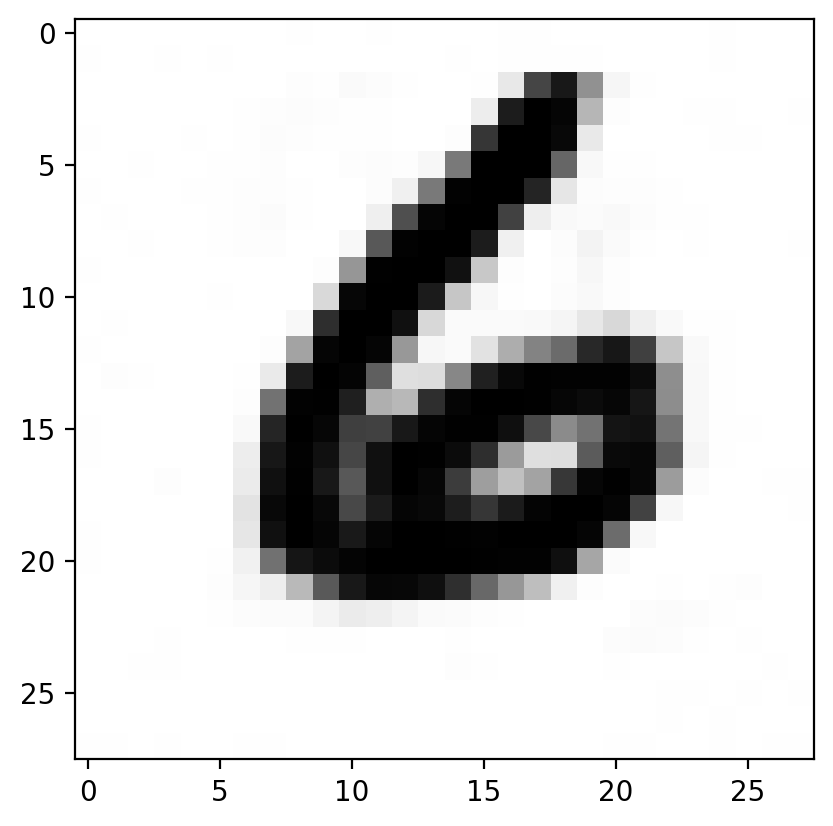

In [76]:
# Let's confirm that the denoiser works.
image_pixels = train_denoised_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the array into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

In [77]:
# To calculate MSE between two datasets we can use scikit-learn:
# https://scikit-learn.org/stable/
from sklearn.metrics import mean_squared_error

# This calcualates MSE on train clean against train denoised,
# which measures how well the autoencoder denoises the training dataset.
# Note that you really want to calculate this metric on validate and/or test dataset.
# Don't let an overfitting model fool you into using it for the graded submission!
mean_squared_error(train_denoised_X, train_clean_X)

0.0050763413

In [78]:
mean_squared_error(test_denoised_X, test_clean_X)

0.005541001

In [79]:
# In order to have reproducible results, we need
# to set the seed values for NumPy and Tensorflow.
# Keep these lines in the same cell as the training code,
# so that you don't accidentally train multiples models
# without reseting the seed.

import numpy as np
import tensorflow as tf

np.random.seed(11)
tf.random.set_seed(11)

hp = HyperParameters()
hp.Fixed('encoder_width', value=best_hyperparameters.values['encoder_width'])
hp.Fixed('learning_rate', value=best_hyperparameters.values['learning_rate'])

autoencoder = build_model(hp)
history = train_model(autoencoder, epochs=100)

/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
383/383 [==============================] - 4s 8ms/step - loss: 0.0413 - val_loss: 0.0232
Epoch 2/100
383/383 [==============================] - 3s 8ms/step - loss: 0.0151 - val_loss: 0.0129
Epoch 3/100
383/383 [==============================] - 3s 8ms/step - loss: 0.0116 - val_loss: 0.0105
Epoch 4/100
383/383 [==============================] - 3s 8ms/step - loss: 0.0100 - val_loss: 0.0093
Epoch 5/100
383/383 [==============================] - 3s 8ms/step - loss: 0.0091 - val_loss: 0.0089
Epoch 6/100
383/383 [==============================] - 3s 8ms/step - loss: 0.0084 - val_loss: 0.0080
Epoch 7/100
383/383 [==============================] - 3s 8ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 8/100
383/383 [==============================] - 3s 8ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 9/100
383/383 [==============================] - 3s 8ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 10/100
383/383 [==============================] - 3s 8ms/step - loss: 0.0067 - val_lo

In [80]:
test_denoised_X = autoencoder.predict(test_noisy_X)
mean_squared_error(test_denoised_X, test_clean_X)

0.0046664393

In [81]:
import os 

model_dir = 'denoiser_model'

os.makedirs(model_dir, exist_ok=True)

# Once you are ready to make the graded submission,
# run the autoencoder on the score noisy dataset.
score_denoised_X = pd.DataFrame(
    autoencoder.predict(score_noisy_X),
    # This is needed to save the file in Parquet format.
    columns=score_noisy_X.columns
)

# Now save it to disc as a Parquet file.
score_denoised_X.to_parquet(f'{model_dir}/score_denoised_x.parquet')

# Next, let's save the model's definition.
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    f.write(json.dumps(json.loads(autoencoder.to_json()), indent=True))

# Finally, let's save the learned parameters.
autoencoder.save_weights(f'{model_dir}/keras_parameters.h5')

# You now have the following files to be uploaded to Moodle:
# 1. This notebook and any other Python code you used to train the final model.
# 2. keras_model.json -- the model's definition
# 3. keras_parameters.h5 -- the model's trained parameters
# 4. score_denoised_X.parquet - the model's output on the score dataset